# Eulerian Video Magnification

<p>Eulerian video magnification reveals temporal variations in videos that are difficult or impossible to see with the naked eye and display them in an indicative manner.
</p>
<p>We are going to create a system which takes in an input video and outputs a video that is motion magnified. The system first decomposes the input video sequence into different
spatial frequency bands, and applies the same temporal filter to all bands. The filtered spatial bands are then amplified by a given factor $\alpha$,
added back to the original signal, and collapsed to generate the output video.</p>


The Algorithm we use is derived from MIT CSAIL's paper, ["Eulerian Video Magnification for Revealing Subtle Changes in the World"](http://people.csail.mit.edu/mrub/papers/vidmag.pdf). I have implemented their paper using Python.


##Overview of the Eulerian video magnification framework


![](https://github.com/joeljose/assets/blob/master/EVM/EVM_flow.png?raw=True)



##There are 5 steps in the algorithm pipeline:
1) Loading the video</br>
2) Spatial decomposition into laplacian pyramids</br>
3) Temporal filtering to extract motion information, and adding that back to the original signal</br>
4) Reconstruction </br>
5) Saving to output video</br>
We will first create helper functions for each of these steps. And finally put them altogether to get our motion magnification method.


## Importing all the essential modules:

In [3]:
import os
import cv2
import numpy as np
import scipy.fftpack
import scipy.signal
from matplotlib import pyplot
import requests

## helper functions for loading and saving videos:

In [4]:

def uint8_to_float(data):
  """
  converts numpy array of type "uint8"(default type when we load through opencv)
  to "float" datatype.
  """
  result = np.ndarray(shape=data.shape, dtype='float')
  result[:] = data * (1. / 255)
  return result


def float_to_uint8(data):
  """
  converts numpy array of type "float" to "uint8" datatype.
  """
  result = np.ndarray(shape=data.shape, dtype='uint8')
  result[:] = data * 255
  return result



def load_video(video_filename):
    """Load a video into a numpy array"""
    video_filename = str(video_filename)
    print("Loading " + video_filename)
    if not os.path.isfile(video_filename):
        raise Exception("File Not Found: %s" % video_filename)
    capture = cv2.VideoCapture(video_filename)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width, height = get_capture_dimensions(capture)
    fps = int(capture.get(cv2.CAP_PROP_FPS))
    x = 0
    vid_frames = np.zeros((frame_count, height, width, 3), dtype='uint8')
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break

        vid_frames[x] = frame
        x += 1
    capture.release()

    return vid_frames, fps


def load_video_float(video_filename):
    """ Returns video as a numpy array of data type float"""
    vid_data, fps = load_video(video_filename)
    return uint8_to_float(vid_data), fps


def get_capture_dimensions(capture):
    """Get the dimensions of a capture"""
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def save_video(video, fps, save_filename='output.avi'):
    """Save a video to disk"""
    video = float_to_uint8(video)
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(save_filename, fourcc, fps, (video.shape[2], video.shape[1]), 1)
    for x in range(0, video.shape[0]):
        res = cv2.convertScaleAbs(video[x])
        writer.write(res)
    print('output saved to '+save_filename)


##Helper functions for Spatial Decomposition(Laplacian pyramids), Temporal filtering, and Reconstruction

In [5]:
def create_gaussian_image_pyramid(image, pyramid_levels):
    """ Creates a gaussian image pyramid for the input image"""
    gauss_copy = np.ndarray(shape=image.shape, dtype="float")
    gauss_copy[:] = image
    img_pyramid = [gauss_copy]
    for pyramid_level in range(1, pyramid_levels):
        gauss_copy = cv2.pyrDown(gauss_copy)
        img_pyramid.append(gauss_copy)

    return img_pyramid


def create_laplacian_image_pyramid(image, pyramid_levels):
    """ Creates a laplacian image pyramid for the input image"""
    gauss_pyramid = create_gaussian_image_pyramid(image, pyramid_levels)
    laplacian_pyramid = []
    for i in range(pyramid_levels - 1):
        laplacian_pyramid.append((gauss_pyramid[i] - cv2.pyrUp(gauss_pyramid[i + 1])))

    laplacian_pyramid.append(gauss_pyramid[-1])
    return laplacian_pyramid


def create_laplacian_video_pyramid(video, pyramid_levels):
    """Creates a laplacian video pyramid for the input video"""
    vid_pyramid = []
    for frame_number, frame in enumerate(video):
        frame_pyramid = create_laplacian_image_pyramid(frame, pyramid_levels)

        for pyramid_level, pyramid_sub_frame in enumerate(frame_pyramid):
            if frame_number == 0:
                vid_pyramid.append(
                    np.zeros((video.shape[0], pyramid_sub_frame.shape[0], pyramid_sub_frame.shape[1], 3),
                                dtype="float"))

            vid_pyramid[pyramid_level][frame_number] = pyramid_sub_frame

    return vid_pyramid


def temporal_bandpass_filter(data, fps, freq_min=0.833, freq_max=1, axis=0, amplification_factor=1):
    """
     filters out the motion information and returns
     an amplified version of the motion information.
    """
    fft = scipy.fftpack.rfft(data, axis=axis)
    frequencies = scipy.fftpack.fftfreq(data.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - freq_min)).argmin()
    bound_high = (np.abs(frequencies - freq_max)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0

    result = np.ndarray(shape=data.shape, dtype='float')
    result[:] = np.abs(scipy.fftpack.ifft(fft, axis=0))
    result *= amplification_factor
    return result


def collapse_laplacian_pyramid(image_pyramid):
    """returns the reconstructed image from the input laplacian pyramid"""
    img = image_pyramid.pop()
    while image_pyramid:
        img = cv2.pyrUp(img) + (image_pyramid.pop() - 0)

    return img


def collapse_laplacian_video_pyramid(pyramid):
    """returns the reconstructed video from the input laplacian video pyramid"""
    i = 0
    while True:
        try:
            img_pyramid = [vid[i] for vid in pyramid]
            pyramid[0][i] = collapse_laplacian_pyramid(img_pyramid)
            i += 1
        except IndexError:
            break
    return pyramid[0]

## Motion magnification function:
Inputs to this method are video data(in numpy array format), fps of the video, lower cutoff frequency, upper cutoff frequency, amplification factor, number of levels in the pyramid, number of levels in the top of the pyramid that we skip for filtering.</br>


In [6]:
def eulerian_magnification(vid_data, fps, freq_min, freq_max, amplification, pyramid_levels=4, skip_levels_at_top=1):
    """ Returns the motion magnified video"""
    print("creating video pyramid....")
    vid_pyramid = create_laplacian_video_pyramid(vid_data, pyramid_levels=pyramid_levels)
    for i, vid in enumerate(vid_pyramid):
        if i < skip_levels_at_top or i >= len(vid_pyramid) - 1:
            # ignore the top and bottom of the pyramid. One end has too much noise and the other end is the
            # gaussian representation
            continue

        bandpassed = temporal_bandpass_filter(vid, fps, freq_min=freq_min, freq_max=freq_max, amplification_factor=amplification)

        vid_pyramid[i] += bandpassed

    print("bandpass filtering "+str([freq_min,freq_max])+"Hz...")
    vid_data = collapse_laplacian_video_pyramid(vid_pyramid)
    print("reconstructing from pyramid...")
    print("Done")
    return vid_data

## Show Frequencies in the video
We have also created a helper function that calculates the mean intensity variation in the input frames of the video. This helps us to figure out the cutoff frequencies required for our video.

In [7]:
def show_frequencies(vid_data, fps, bounds=None):
    """Graph the average value of the video as well as the frequency strength"""
    averages = []

    if bounds:
        for x in range(1, vid_data.shape[0] - 1):
            averages.append(vid_data[x, bounds[2]:bounds[3], bounds[0]:bounds[1], :].sum())
    else:
        for x in range(1, vid_data.shape[0] - 1):
            averages.append(vid_data[x, :, :, :].sum())

    averages = averages - min(averages)

    charts_x = 1
    charts_y = 2
    pyplot.figure(figsize=(20, 10))
    pyplot.subplots_adjust(hspace=.7)

    pyplot.subplot(charts_y, charts_x, 1)
    pyplot.title("Pixel Average")
    pyplot.xlabel("Time")
    pyplot.ylabel("Brightness")
    pyplot.plot(averages)

    freqs = scipy.fftpack.fftfreq(len(averages), d=1.0 / fps)
    fft = abs(scipy.fftpack.fft(averages))
    idx = np.argsort(freqs)

    pyplot.subplot(charts_y, charts_x, 2)
    pyplot.title("FFT")
    pyplot.xlabel("Freq (Hz)")
    freqs = freqs[idx]
    fft = fft[idx]

    freqs = freqs[len(freqs) // 2 + 1:]
    fft = fft[len(fft) // 2 + 1:]
    pyplot.plot(freqs, abs(fft))

    pyplot.show()

## Downloading the input video to our notebook
To do a demo of our motion magnification algorithm we use a video which was used in the original paper. </br>
You can alternatively use you own video as input too. You will have to upload the video to the colab notebook, and rename the 'filename' variable as the name of your video.</br>
If you want to try your own video, comment the first line in the next code block and Uncomment the next line and enter your own filename.


In [8]:
#filename = "video.mp4" # If you want to try your own video, comment this line
                      # and Uncomment the next line and enter your own filename


filename = "Forward.mp4"
!ffmpeg -i {filename} -vf scale=640:360 small_{filename}
filename = f"small_{filename}"



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

##helper function for downloading video
You can skip the downloading part in this notebook if you are using your own video.

In [8]:
def download_file(url, dest_filename):
    """Downloads the file in given url"""
    if os.path.isfile(dest_filename):
        print('Already Downloaded: %s to %s' % (url, dest_filename))
        return
    print('Downloading: %s to %s' % (url, dest_filename))

    response = requests.get(url, stream=True)
    if not response.ok:
        raise Exception("Couldn't download file")

    with open(dest_filename, 'wb') as fp:
        for block in response.iter_content(1024):
            fp.write(block)

## Downloading....
Skip the next code block if you are using your own video.

In [9]:
download_file('http://people.csail.mit.edu/mrub/evm/video/face.mp4',filename)

NameError: name 'download_file' is not defined

## Final Demo on "input.mp4"
load the video and use show_frequencies to see the frequency range of the input video.

Loading small_Forward.mp4


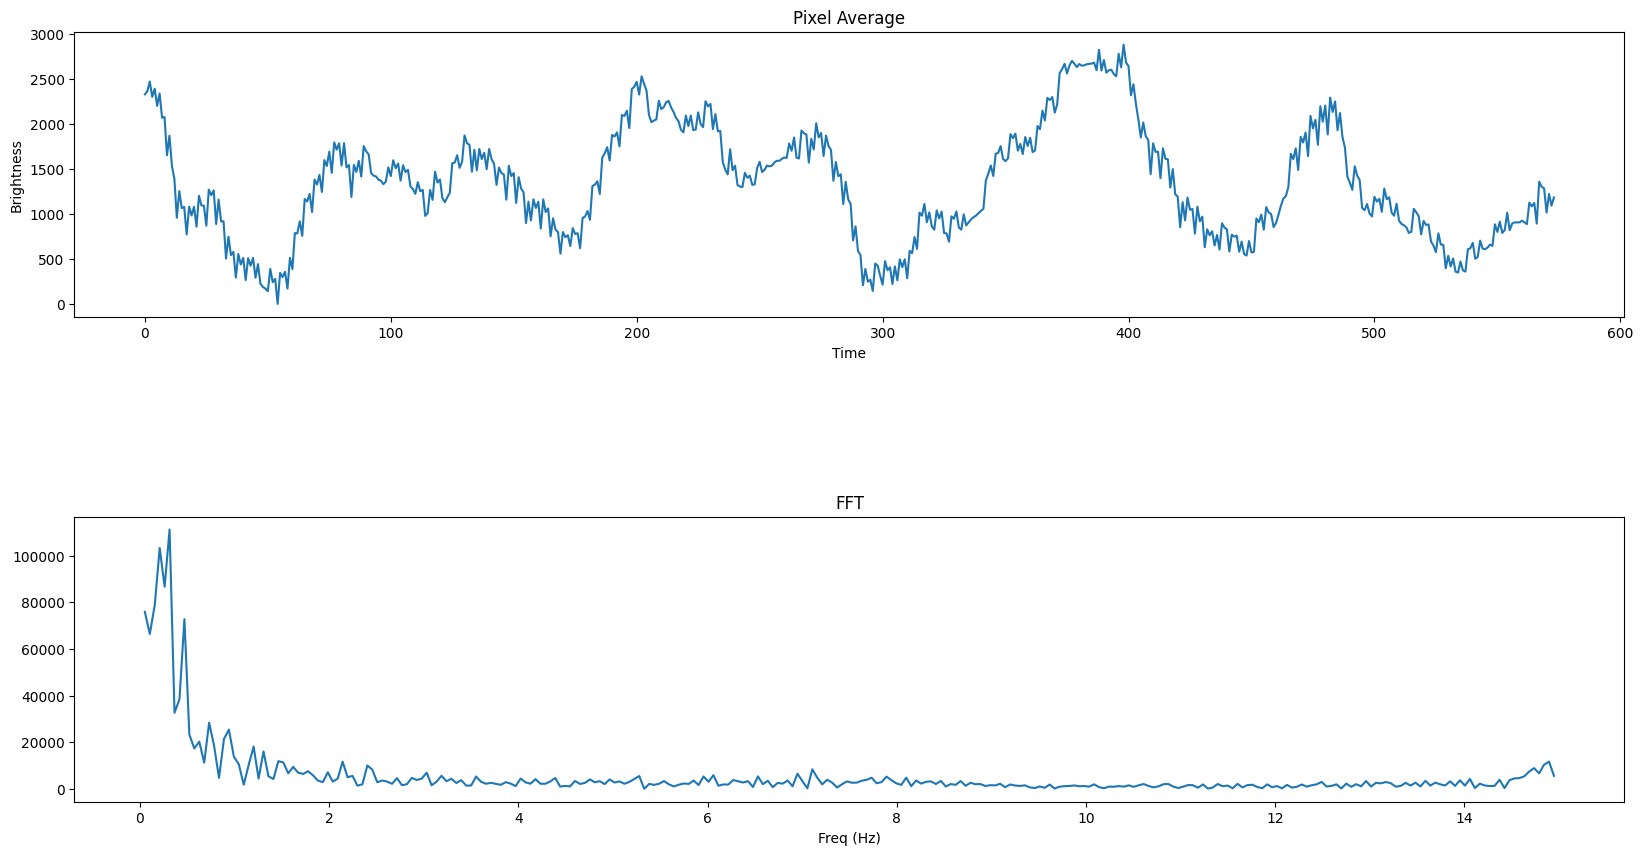

In [11]:
vid, fps = load_video_float(filename)
show_frequencies(vid,fps)

You can use this information for making changes in the cutoff frequencies in the next code block if you want to.

In [15]:
lower_hertz = 0.1
upper_hertz = 0.5
amplification_factor = 20
pyramid_levels = 4

Motion magnify the loaded video:

In [ ]:
mag_vid = eulerian_magnification(
    vid, fps,
    freq_min=lower_hertz,
    freq_max=upper_hertz,
    amplification=amplification_factor,
    pyramid_levels=pyramid_levels
)

creating video pyramid....


save video to disk.

In [14]:
out_name = filename.split(".")[0] + "_levels_" + str(pyramid_levels) + "_min_" + str(
    lower_hertz) + "_max_" + str(upper_hertz) + "_amp_" + str(amplification_factor)+'.avi'

save_video(mag_vid, fps, out_name)

output saved to small_Forward_levels_3_min_0.1_max_0.5_amp_20.avi


##Conclusion
To amplify motion, EVM does not perform feature
tracking or optical flow computation, but merely magnifies temporal color changes using spatio-temporal processing. This Eulerian based method, which temporally processes pixels in a fixed spatial
region, successfully reveals informative signals and amplifies small motions in real-world videos.

One drawback of this method is that we can see that we get artifacts in our videos as we increase amplification factor.


## If you like this content, follow me
<a href="https://twitter.com/joelk1jose" target="_blank"><img class="ai-subscribed-social-icon" src="https://github.com/joeljose/assets/blob/master/images/tw.png?raw=True" width="30"></a>
<a href="https://github.com/joeljose" target="_blank"><img class="ai-subscribed-social-icon" src="https://github.com/joeljose/assets/blob/master/images/gthb.png?raw=True" width="30"></a>
<a href="https://www.linkedin.com/in/joel-jose-527b80102/" target="_blank"><img class="ai-subscribed-social-icon" src="https://github.com/joeljose/assets/blob/master/images/lnkdn.png?raw=True" width="30"></a>

<h3 align="center">Show your support by starring the repository 🙂</h3>